# ZTF

In [2]:
import os
print(os.getcwd())
os.chdir('../')
print(os.getcwd())

/Users/riley/Desktop/RAFTS/Notebooks
/Users/riley/Desktop/RAFTS


In [3]:
import matplotlib.pyplot as plt
import numpy as np

import astropy.units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
from astropy.wcs import WCS
from astropy.visualization import astropy_mpl_style
import astropy.io.votable as votable

from utils import *
from config import *

plt.style.use(astropy_mpl_style)

## ZTF Lightcurves

In [4]:
def get_ztf_votable(mintime, maxtime, ra, dec, radius, band):
    print('https://irsa.ipac.caltech.edu/cgi-bin/ZTF/nph_light_curves?POS=CIRCLE%20'
            +str(ra)+'%20'+str(dec)+'%20'+str(radius)+'&TIME='+str(mintime)+'%20'+str(maxtime)+'&BANDNAME='+band)
    return votable.parse('https://irsa.ipac.caltech.edu/cgi-bin/ZTF/nph_light_curves?POS=CIRCLE%20'
                    +str(ra)+'%20'+str(dec)+'%20'+str(radius)+'&TIME='+str(mintime)+'%20'+str(maxtime)+'&BANDNAME='+band)

vo = get_ztf_votable(58882,58890,get_flr_coord('flare1')[0],get_flr_coord('flare1')[1], 0.0001, 'g')

https://irsa.ipac.caltech.edu/cgi-bin/ZTF/nph_light_curves?POS=CIRCLE%20186.09002468556912%2065.31234685437119%200.0001&TIME=58882%2058890&BANDNAME=g


'Figures/ZTF_819113200001466_ra186_dec65_mjd58882_lc.png'

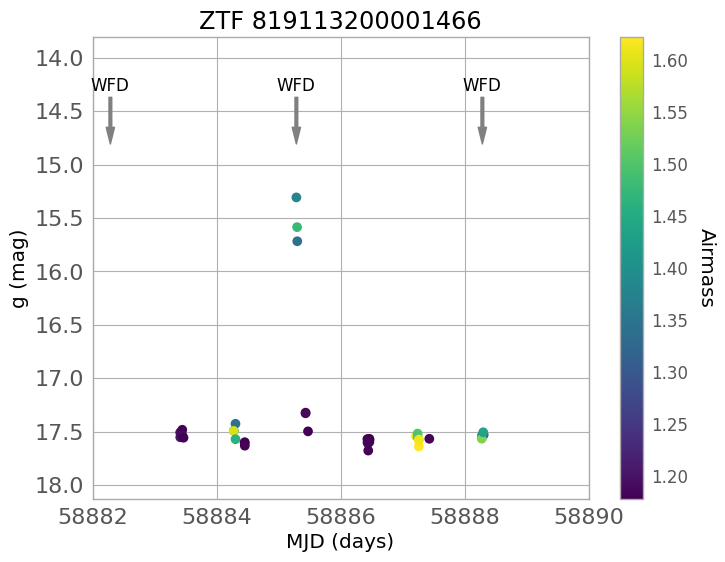

In [5]:
def plot_ztf_lcv(mintime, maxtime, ra, dec, radius, band, votbl=None):

    if votbl is None:
        votbl = get_ztf_votable(mintime, maxtime, ra, dec, radius, band)

    else:
        assert isinstance(votbl, votable.tree.VOTableFile), "Object is not a VOTable"
    
    table = votbl.get_first_table()
    data = table.array  
    ids = np.unique(data['oid'])
    flarename = "ZTF_" + str(ids[0]) + "_ra" + str(ra).split('.')[0] + "_dec" + str(dec).split('.')[0] + "_mjd" + str(int(mintime)) 

    am1 = np.zeros(len(data['mjd'][data['oid'] == ids[0]]))
    am2 = np.zeros(len(data['mjd'][data['oid'] == ids[1]]))

    mtn = EarthLocation.of_site('Palomar')

    i=0
    j=0
    for ra, dec, t in zip(data['ra'][data['oid'] == ids[0]], data['dec'][data['oid'] == ids[0]], data['mjd'][data['oid'] == ids[0]]):

        mjd = Time(t, format='mjd')
        flraltaz = SkyCoord(ra = ra * u.degree, dec = dec*u.degree).transform_to(AltAz(obstime = mjd, location=mtn))
        zd = 90 - flraltaz.alt.value
        am1[i] = 1 / np.cos(np.deg2rad(zd))
        i+=1

    for ra, dec, t in zip(data['ra'][data['oid'] == ids[1]], data['dec'][data['oid'] == ids[1]], data['mjd'][data['oid'] == ids[1]]):

        mjd = Time(t, format='mjd')
        flraltaz = SkyCoord(ra = ra * u.degree, dec = dec*u.degree).transform_to(AltAz(obstime = mjd, location=mtn))
        zd = 90 - flraltaz.alt.value
        am2[j] = 1 / np.cos(np.deg2rad(zd))
        j+=1

    plt.scatter(data['mjd'][data['oid'] == ids[0]], data['mag'][data['oid'] == ids[0]], 
            c = am1, cmap='viridis')
    plt.scatter(data['mjd'][data['oid'] == ids[1]], data['mag'][data['oid'] == ids[1]], 
                c = am2, cmap='viridis')

    flaremax = data['mag'][data['oid'] == ids[0]][(data['mjd'][data['oid'] == ids[0]] >= mintime) * (data['mjd'][data['oid'] == ids[0]] <= maxtime)].max()
    flaremin = data['mag'][data['oid'] == ids[0]][(data['mjd'][data['oid'] == ids[0]] >= mintime) * (data['mjd'][data['oid'] == ids[0]] <= maxtime)].min()
    plt.ylim(flaremax + 0.5, flaremin - 1.5)
    plt.xlim(mintime, maxtime)
    plt.xlabel('MJD (days)')
    plt.ylabel('g (mag)')
    plt.tick_params(labelsize=16)

    for i in np.arange(int(mintime)+0.288, int(maxtime)+0.288, 3):
        plt.annotate('WFD', xy = (i,flaremin - 0.5), xytext=(i,flaremin - 1.0), horizontalalignment='center', 
        arrowprops = dict(facecolor='gray', color='grey', width=2, headwidth=6))

    cbar = plt.colorbar()
    cbar.set_label('Airmass', rotation=270, labelpad=20)
    plt.title("ZTF {}".format(ids[0]))
    filename = 'Figures/{}_lc.png'.format(flarename)
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    return filename

plot_ztf_lcv(58882,58890,get_flr_coord('flare1')[0],get_flr_coord('flare1')[1], 0.0001, 'g', votbl=vo)

## ZTF Delta Position Plots:

In [6]:
filename = "srcext/20200206287824_000819_sciimg.fits"

hdulist = fits.open(filename)

In [7]:
header = hdulist[0].header
header

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                  -32                                                  
NAXIS   =                    2                                                  
NAXIS1  =                 3072                                                  
NAXIS2  =                 3080                                                  
BUNIT   = 'Data Value'                                                          
ORIGIN  = 'Zwicky Transient Facility' / Data origin                             
OBSERVER= 'ZTF Robotic Observing Software' / Observer                           
ROBOSOFT= '0.99.12  December 9, 2019' / Robotic software version                
FITSSOFT= '0.99.12  December 9, 2019' / FITS software version                   
INSTRUME= 'ZTF/MOSAIC'         / Instrument name                                
DETECTOR= '        '           / Detector controller                            
DETSOFT = '        '        

In [8]:
from astropy import units as u
from astropy.units import hourangle, degree, hour
from astropy.coordinates import SkyCoord, AltAz, EarthLocation, FK5, Angle
from astropy.time import Time, TimeDelta
import datetime
import time
LaPalmaLatitude = (28 + 45 / 60 + 49 / 60 / 60) * u.degree
LaPalmaLongitude = - (17 + 53/ 60 + 41 / 60 / 60) * u.degree
SubLatitude = (19 + 49 / 60 + 32 / 3600) * u.degree 
SubLongitude = - (155 + 28 / 60 + 34 / 3600) * u.degree 
APOLatitude = (32 + 46 / 60 + 49 / 60 / 60) * u.degree 
APOLongitude = - (105 + 49/60 +  133 / 60 / 60) * u.degree 
KPLatitude = (31 + 57 / 60 + 12 / 60 / 60 ) * u.degree 
KPLongitude = -(7*15 + 26 / 60 + 28 / 60 / 60 ) * u.degree
LSLatitude = (29 + 15 / 60 + 27 / 60 / 60) * u.degree 
LSLongitude = - (70 + 44 / 60 + 15 / 60 / 60) * u.degree 
c = SkyCoord(ra=hdulist[0].header["TELRA"], dec=hdulist[0].header["TELDEC"], unit=(u.hourangle, u.deg))
print("image center coordinates", c.to_string())

image center coordinates 180 62.15


In [9]:
locapo = EarthLocation(lat=APOLatitude,
          lon=APOLongitude, height=2788 * u.meter)
loclp = EarthLocation(lat=LaPalmaLatitude,
          lon=LaPalmaLongitude, height=2396 * u.meter)
locsub = EarthLocation(lat=SubLatitude,
          lon=SubLongitude, height=4139 * u.meter) 
locls = EarthLocation(lat=LSLatitude,
          lon=LSLongitude, height=2400 * u.meter) 

lockp = EarthLocation(lat=KPLatitude,
          lon=KPLongitude, height=1925 * u.meter) 

locpal = EarthLocation(lat=header["OBSLAT"],
          lon=header["OBSLON"], height=header["OBSALT"] * u.meter) 

# Read the start time and exposure time of the image from the header
#sidtime = Time(datetime.datetime.strptime(header['DATE-OBS'] + 'T' + 
#                             header['TAIHMS'].split('.')[0], 
#                             '%Y-%m-%dT%H:%M:%S'),# %HH:%MM:%SS.SS'), 
#                 location=locapo)

sidtime = Time(header["OBSMJD"], format='mjd', location=locpal)
print(sidtime)
# determine the sidereal time at the mid point of the exposure
sidereal = sidtime.sidereal_time('mean')
print("Sidereal time", sidereal)

58885.2879051
Sidereal time 8h10m41.78829276s


In [10]:
def compute_paral_angles(header, loc, 
                         ra_key="RA", dec_key="DEC", exptime="EXPTIME",
                         acqtime_key="TAIHMS", date_key='DATE-OBS'):
    """Calculates the parallactic angle for a frame, taking coordinates and
    local sidereal time from fits-headers (frames taken in an alt-az telescope 
    with the image rotator off).
    
    The coordinates in the header are assumed to be J2000 FK5 coordinates.
    The spherical trigonometry formula for calculating the parallactic angle
    is taken from Astronomical Algorithms (Meeus, 1998).
    
    Parameters
    ----------
    header : dictionary
        Header of current frame.
    ra_key, dec_key, exptime, lst_key, acqtime_key, date_key : strings
        Keywords where the values are stored in the header.
        
    Returns
    -------
    pa.value : float
        Parallactic angle in degrees for current header (frame).
    """                                    
    latitude = loc.lat

    sidtime = Time(header[date_key], format='mjd', location=loc)
    
    print("zen angle {}".format(AltAz(alt=header["ELVATION"] * u.degree, 
                             az=header["AZIMUTH"] * u.degree,
                obstime=sidtime, 
                 location=loc
                 ).zen))
    
    # equatorial coordinates in J2000
    ra = header[ra_key]                                                         
    dec = header[dec_key]  
    r, m =  int(ra / 15) , int((ra / 15 - int(ra / 15)) * 60)
    s = ((ra / 15 - r) * 60. - m) * 60
    print("ra in hh:mm:ss", r, m, s)

    d, m =  int(dec) , int((dec - int(dec)) * 60)
    s = ((dec - d) * 60. - m) * 60
    print("dec in dd:mm:ss", d, m, s)

    coor = SkyCoord(ra=ra, dec=dec, 
                    unit=(degree,degree), frame=FK5, 
                    equinox='J2000.0')
    
    # recalculate for DATE-OBS (precession)
    coor_curr = coor.transform_to(FK5(equinox=sidtime))
    print("corrected coordinates", coor_curr.to_string(style='dms'))
    # new ra and dec in radians
    ra_curr = coor_curr.ra                                                      
    dec_curr = coor_curr.dec
    
    lst = sidtime.sidereal_time('mean')
    print("time {}, sidereal time {:.2f}".format(sidtime, lst))

    # for long exposures (spectra) you would need to calculate the mid time
    ##lst_split = lst.split(':')
    #exp_delay = (float(header[exptime]) * 0.5) / 3600
    ## solar to sidereal time
    #exp_delay = exp_delay * 1.0027 * u.hour                                                
    ##print(lst.hour)

    # hour angle in degrees 
    hour_angle = ((lst.hour) - ra_curr.hour) * 15                          
    hour_angle = np.deg2rad(hour_angle)      
    print("HA: {} ({:.2f} rad)".format(lst, hour_angle))      

    print("observatory latitude {:.2f}".format(latitude))
    latitude = np.deg2rad(latitude)                                             
    # PA formula from Astronomical Algorithms 
    return (pa(hour_angle, latitude, dec_curr.radian)).value
    

print("Parallactic Angle {:.2f}".format(compute_paral_angles(header, 
                              locpal, ra_key="TELRAD", dec_key="TELDECD", acqtime_key="OBLST", date_key="OBSMJD")))

zen angle 45.89 deg
ra in hh:mm:ss 12 0 0.0
dec in dd:mm:ss 62 8 59.999999999994884
corrected coordinates 180d15m25.29209345s 62d02m17.21658598s
time 58885.2879051, sidereal time 8.18 hourangle
HA: 8.178274525768026 hourangle (-1.01 rad)
observatory latitude 33.36 deg
Parallactic Angle -91.78


In [11]:
def compute_star_paral_angles_from_header(header, sra, sdec, loc, 
                         ra_key="RA", dec_key="DEC", exptime="EXPTIME",
                         acqtime_key="TAIHMS", date_key='DATE-OBS', verbose=True):
    """Calculates the parallactic angle for a frame, taking coordinates and
    local sidereal time from fits-headers (frames taken in an alt-az telescope 
    with the image rotator off).
    
    The coordinates in the header are assumed to be J2000 FK5 coordinates.
    The spherical trigonometry formula for calculating the parallactic angle
    is taken from Astronomical Algorithms (Meeus, 1998).
    
    Parameters
    ----------
    header : dictionary
        Header of current frame.
    ra_key, dec_key, exptime, lst_key, acqtime_key, date_key : strings
        Keywords where the values are stored in the header.
        
    Returns
    -------
    pa.value : float
        Parallactic angle in degrees for current header (frame).
    """                                    
    latitude = loc.lat

    sidtime = Time(header[date_key], format='mjd', location=loc)

    if verbose:
        print("zen angle {}".format(AltAz(alt=header["ELVATION"] * u.degree, 
                                az=header["AZIMUTH"] * u.degree,
                    obstime=sidtime, 
                    location=loc
                    ).zen))
    
    # equatorial coordinates in J2000
    ra = sra                                                 
    dec = sdec
    r, m =  int(ra / 15) , int((ra / 15 - int(ra / 15)) * 60)
    s = ((ra / 15 - r) * 60. - m) * 60
    if verbose:
        print("ra in hh:mm:ss", r, m, s)

    d, m =  int(dec) , int((dec - int(dec)) * 60)
    s = ((dec - d) * 60. - m) * 60
    if verbose:
        print("dec in dd:mm:ss", d, m, s)

    coor = SkyCoord(ra=ra, dec=dec, 
                    unit=(degree,degree), frame=FK5, 
                    equinox='J2000.0')
    
    # recalculate for DATE-OBS (precession)
    coor_curr = coor.transform_to(FK5(equinox=sidtime))
    if verbose:
        print("corrected coordinates", coor_curr.to_string(style='dms'))
    # new ra and dec in radians
    ra_curr = coor_curr.ra                                                      
    dec_curr = coor_curr.dec
    
    lst = sidtime.sidereal_time('mean')
    if verbose:
        print("time {}, sidereal time {:.2f}".format(sidtime, lst))

    # for long exposures (spectra) you would need to calculate the mid time
    ##lst_split = lst.split(':')
    #exp_delay = (float(header[exptime]) * 0.5) / 3600
    ## solar to sidereal time
    #exp_delay = exp_delay * 1.0027 * u.hour                                                
    ##print(lst.hour)

    # hour angle in degrees
    hour_angle = ((lst.hour) - ra_curr.hour) * 15                          
    hour_angle = np.deg2rad(hour_angle)
    if verbose:
        print("HA: {} ({:.2f} rad)".format(lst, hour_angle))      
    if verbose:
        print("observatory latitude {:.2f}".format(latitude))
    latitude = np.deg2rad(latitude)                                             
    # PA formula from Astronomical Algorithms 
    return (pa(hour_angle, latitude, dec_curr.degree)).value

In [12]:
def img_deltas(im1,im2,flr_coord,det_thr=10,ana_thr=10):

    mjd1 = Time(im1[0:4]+'-'+im1[4:6]+'-'+im1[6:8], format='isot').mjd + float(im1[8:14])
    mjd2 = Time(im2[0:4]+'-'+im2[4:6]+'-'+im2[6:8], format='isot').mjd + float(im2[8:14])

    #Read in images
    ep1file = getsciimg(filefracday=im1[0:14], paddedfield=im1[14:20], filtercode=im1[20:22],paddedccdid=im1[22:24],imgtypecode=im1[24:25],qid=im1[25:26])
    ep2file = getsciimg(filefracday=im2[0:14], paddedfield=im2[14:20], filtercode=im2[20:22],paddedccdid=im2[22:24],imgtypecode=im2[24:25],qid=im2[25:26])
    #Do SExtractor stuff
    ep1cat = srcext(im1[0:14]+'_'+im1[14:20]+'_'+'sciimg.fits', det_thresh=det_thr, ana_thresh=ana_thr, catname = im1[0:14]+'_'+im1[14:20]+'.cat')
    ep2cat = srcext(im2[0:14]+'_'+im2[14:20]+'_'+'sciimg.fits', det_thresh=det_thr, ana_thresh=ana_thr, catname = im2[0:14]+'_'+im2[14:20]+'.cat')
    
    #Crossmatch catalogs
    ind, d2d, d3d = xmatch(ep1cat, ep2cat)
   
    if len(ep1cat["ALPHA_SKY"]) > len(ep2cat["ALPHA_SKY"]):
        ep1ra = ep1cat["ALPHA_SKY"].values[ind]
        ep1dec = ep1cat["DELTA_SKY"].values[ind]
        ep2ra = ep2cat["ALPHA_SKY"].values
        ep2dec = ep2cat["DELTA_SKY"].values

    if len(ep1cat["ALPHA_SKY"]) < len(ep2cat["ALPHA_SKY"]):
        ep1ra = ep1cat["ALPHA_SKY"].values
        ep1dec = ep1cat["DELTA_SKY"].values
        ep2ra = ep2cat["ALPHA_SKY"].values[ind]
        ep2dec = ep2cat["DELTA_SKY"].values[ind]

    if len(ep1cat["X_IMAGE"]) > len(ep2cat["X_IMAGE"]):
        ep1x = ep1cat["X_IMAGE"].values[ind]
        ep1y = ep1cat["Y_IMAGE"].values[ind]
        ep2x = ep2cat["X_IMAGE"].values
        ep2y = ep2cat["Y_IMAGE"].values

    if len(ep1cat["X_IMAGE"]) < len(ep2cat["X_IMAGE"]):
        ep1x = ep1cat["X_IMAGE"].values
        ep1y = ep1cat["Y_IMAGE"].values
        ep2x = ep2cat["X_IMAGE"].values[ind]
        ep2y = ep2cat["Y_IMAGE"].values[ind]

    with fits.open('srcext/20200206287824_000819_sciimg.fits') as hdu:
        ep1header = hdu[0].header

    with fits.open('srcext/20200206302627_000819_sciimg.fits') as hdu:
        ep2header = hdu[0].header
        
    w1 = WCS(ep1header)
    w2 = WCS(ep2header)
    zen1 = calc_zenith(mjd1)
    zen2 = calc_zenith(mjd2)
    zen1x, zen1y = w1.wcs_world2pix(zen1.ra, zen1.dec, 1)
    zen2x, zen2y = w2.wcs_world2pix(zen2.ra, zen2.dec, 1)
    zen_ra = zen1.ra.value
    zen_dec = zen1.dec.value

    flr_ra = flr_coord[0]
    flr_dec = flr_coord[1]
   
    ##COMPUTE AIRMASSES & PARALLACTIC ANGLES-------------------------
    ep1am = np.zeros(len(ep1ra))
    ep2am = np.zeros(len(ep2ra))
    ep1pa = np.zeros(len(ep1ra))
    ep2pa = np.zeros(len(ep2ra))

    i=0
    j=0
    for ra, dec in zip(ep1ra, ep1dec):

        mtn = EarthLocation.of_site('Palomar')
        mjd = Time(58885.28807871, format='mjd')
        altaz = SkyCoord(ra = ra * u.degree, dec = dec*u.degree).transform_to(AltAz(obstime = mjd, location=mtn))
        zd = 90 - altaz.alt.value
        ep1am[i] = 1 / np.cos(np.deg2rad(zd))
        ep1pa[i] = celest_to_pa(ra, dec, mjd, mtn)
        i+=1

    for ra, dec in zip(ep2ra, ep2dec):

        mtn = EarthLocation.of_site('Palomar')
        mjd = Time(58885.3026273, format='mjd')
        altaz = SkyCoord(ra = ra * u.degree, dec = dec*u.degree).transform_to(AltAz(obstime = mjd, location=mtn))
        zd = 90 - altaz.alt.value
        ep2am[j] = 1 / np.cos(np.deg2rad(zd))
        ep2pa[j] = celest_to_pa(ra, dec, mjd, mtn)
        j+=1


    imaltaz = SkyCoord(ra = ep1header["TELRAD"] * u.degree, dec = ep1header["TELDECD"]*u.degree).transform_to(AltAz(obstime = mjd, location=mtn))
    zd = 90.0 * u.degree - imaltaz.alt
    #print("Telescope zenith angle: {}".format(zd))

    mean_ams = (ep1am + ep2am) / 2
    #-------------------------------------------

    #Calc delta coords, conv to arcsec
    d_ra = (ep1ra - ep2ra) * 3600
    d_dec = (ep1dec - ep2dec) * 3600
    d_x = ep1x - ep2x
    d_y = ep1y - ep2y
    d_pa = ep1pa - ep2pa

    #Calc zenith delta coord, conv to arcsec
    d_zra = (ep1ra.mean() - zen_ra) * 3600
    d_zdec = (ep1dec.mean() - zen_dec) * 3600
    d_zx = ep1x.mean() - zen1x
    d_zy = ep1y.mean() - zen1y

    #Calc centroid
    centroid = (sum(d_ra) / len(d_ra), sum(d_dec) / len(d_dec))

    #Find Flare star
    f_ind = np.where( (np.abs(ep1ra - flr_ra) == np.abs(ep1ra - flr_ra).min()) * (np.abs(ep1dec - flr_dec) == np.abs(ep1dec - flr_dec).min()) )[0][0]

    return d_x, d_y, mean_ams, d_pa, f_ind

d_x, d_y, mean_ams, d_pa, f_ind = img_deltas(get_img_string('flare1ep1'), 
                                             get_img_string('flare1ep3'), 
                                             get_flr_coord('flare1'))

Querying: https://irsa.ipac.caltech.edu/ibe/data/ztf/products/sci/2020/0206/287824/ztf_20200206287824_000819_zg_c13_o_q2_sciimg.fits
Querying: https://irsa.ipac.caltech.edu/ibe/data/ztf/products/sci/2020/0206/302627/ztf_20200206302627_000819_zg_c13_o_q2_sciimg.fits
Making SExtractor catalog of 20200206287824_000819_sciimg.fits...
This catalogue already exists, moving on...
Making SExtractor catalog of 20200206302627_000819_sciimg.fits...
This catalogue already exists, moving on...
Matching catalogs...


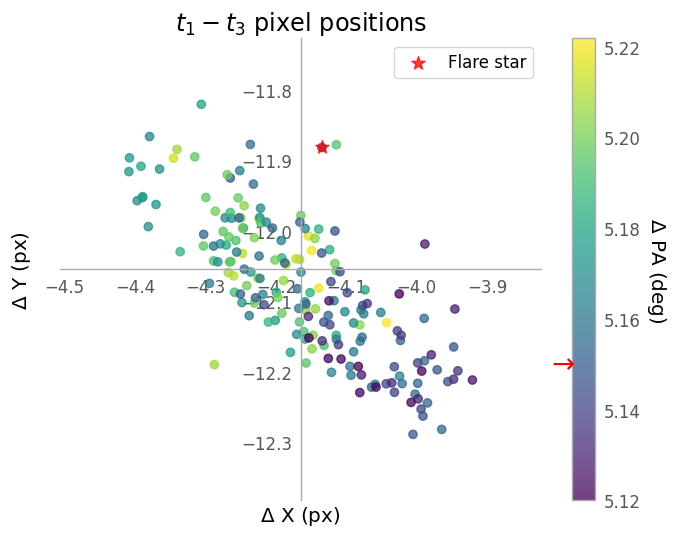

In [13]:
def dpix_plot(d_x, d_y, clr_vector, f_ind, clr_label=r'$\Delta$ PA (deg)', vmin=None, vmax=None):
    #Clip outliers
    x=d_x.copy()
    y=d_y.copy()
    clr_v=clr_vector.copy()
    x[np.concatenate([np.where((d_x > np.percentile(d_x, 98)) | (d_x < np.percentile(d_x, 2)))[0], 
                    np.where((d_y > np.percentile(d_y, 98)) | (d_y < np.percentile(d_y, 2)))[0]])] = np.nan
    y[np.concatenate([np.where((d_x > np.percentile(d_x, 98)) | (d_x < np.percentile(d_x, 2)))[0], 
                    np.where((d_y > np.percentile(d_y, 98)) | (d_y < np.percentile(d_y, 2)))[0]])] = np.nan
    clr_v[np.concatenate([np.where((d_x > np.percentile(d_x, 98)) | (d_x < np.percentile(d_x, 2)))[0], 
                    np.where((d_y > np.percentile(d_y, 98)) | (d_y < np.percentile(d_y, 2)))[0]])] = np.nan

    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    s = ax.scatter(x, y, c=clr_v, cmap='viridis', vmin=vmin, vmax=vmax, alpha=0.75)
    ax.scatter(x[f_ind], y[f_ind], color='red', s=100, marker='*', label='Flare star', alpha=0.75)
    #ax.plot([-4.3,d_zx],[-12.0,d_zy], c='gray',ls='--', label="to zenith")
    xlim = ax.get_xlim()
    cbar = fig.colorbar(s)
    cbar.set_label(clr_label, rotation=270, labelpad=20)
    cbar.ax.text(cbar.ax.get_xlim()[0] - (cbar.ax.get_xlim()[1] - cbar.ax.get_xlim()[0]) / 2, clr_v[f_ind], s=r'$\rightarrow$', fontsize=20, 
                color='red', ha='center', va='center', transform=cbar.ax.transData)

    # Move left y-axis and bottim x-axis to centre, passing through (0,0)
    ax.spines['left'].set_position('center')
    ax.spines['bottom'].set_position('center')

    # Eliminate upper and right axes
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')

    # Show ticks in the left and lower axes only
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

    ax.set_xlabel(r"$\Delta$ X (px)", labelpad=150)
    ax.set_ylabel(r"$\Delta$ Y (px)", labelpad=150)
    ax.set_title(r'$t_1 - t_3$ pixel positions')
    #ax.set_xticks([-0.4,-0.2,0.2,0.4])
    ax.set_xlim(np.nanmin(x)- (np.nanmax(x) - np.nanmin(x))*0.2, np.nanmax(x) + (np.nanmax(x) - np.nanmin(x))*0.2)
    ax.set_ylim(np.nanmin(y)- (np.nanmax(y) - np.nanmin(y))*0.2, np.nanmax(y) + (np.nanmax(y) - np.nanmin(y))*0.2)
    ax.legend()
    ax.grid(False)

    plt.gca().set_aspect('equal')

dpix_plot(d_x,d_y,d_pa,f_ind)
plt.savefig('Figures/dpix_pa.png', dpi=500, bbox_inches='tight')

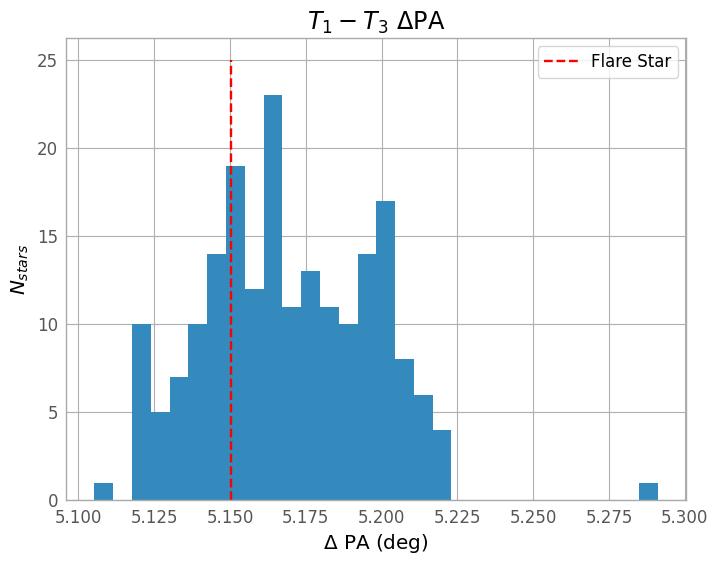

In [14]:
plt.hist(d_pa, bins=30)
plt.vlines(d_pa[f_ind], 0, 25, color='r', ls='--', label='Flare Star')
plt.xlabel(r'$\Delta$ PA (deg)')
plt.ylabel(r'$N_{stars}$')
plt.title(r'$T_1-T_3$ $\Delta$PA')
plt.legend();

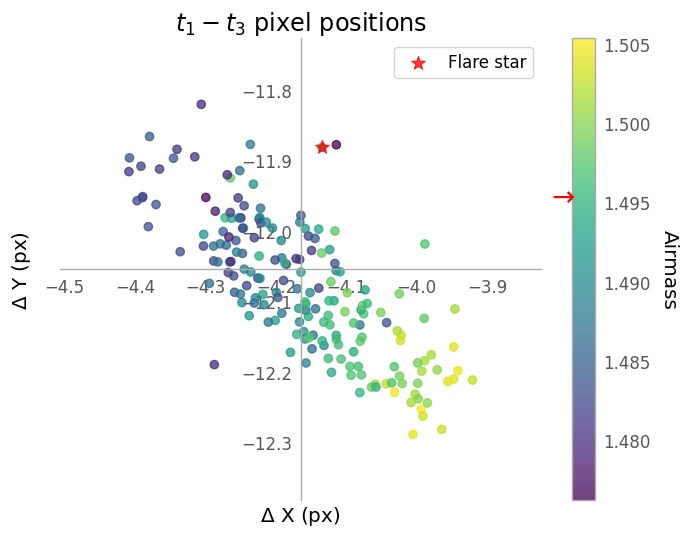

In [15]:
dpix_plot(d_x,d_y,mean_ams,f_ind, 'Airmass')
plt.savefig('Figures/dpix_am.png', dpi=500, bbox_inches='tight')

## SDSS Check

Zenith altaz: <SkyCoord (AltAz: obstime=51633.37402175926, location=(-1463969.30185172, -5166673.34223433, 3434985.71204565) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (125.14962035, 90.)>
Zenith coords RA: 216.8797285184533 deg, Dec: 32.78231546411973 deg
Alt = 52.524228432651626 deg
Az = 339.43015700221963 deg
Zenith angle: 37.47577156734732 deg
Airmass: 1.2600636657164104


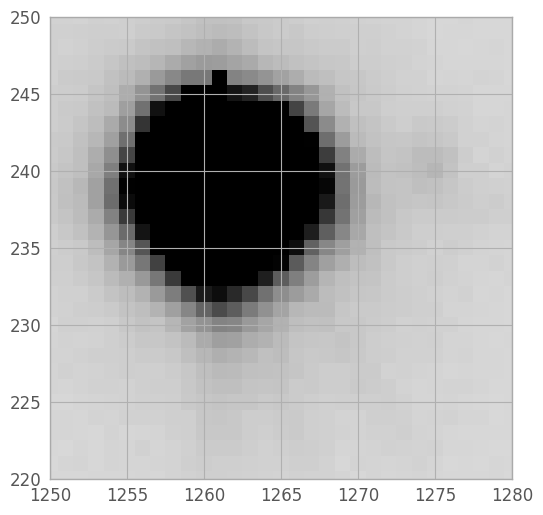

In [22]:
with fits.open('frame-g-001302-4-0379.fits') as hdu:

    sdss_data1 = hdu[0].data
    sdss_header1 = hdu[0].header

date = sdss_header1['DATE-OBS']
hms = sdss_header1['TAIHMS']


w = WCS(sdss_header1)
mtn = EarthLocation.of_site('Apache Point Observatory')
mjd = Time(Time(date + ' ' + hms, format='iso', scale='utc').mjd, format='mjd')

zen = SkyCoord(AltAz(alt=90 * u.degree, az=0 * u.degree, obstime = mjd, location=mtn)).transform_to(ICRS())
zenaltaz = zen.transform_to(AltAz(obstime = mjd, location=mtn))
print('Zenith altaz:', zenaltaz)
zenx, zeny = w.wcs_world2pix(zen.ra, zen.dec, 1)
print('Zenith coords RA: {0}, Dec: {1}'.format(zen.ra, zen.dec))

tele_ra = sdss_header1['RA']
tele_dec = sdss_header1['DEC']
tele_az = sdss_header1['AZ']
tele_alt  = sdss_header1['ALT']

starcoord = SkyCoord(ra=get_flr_coord('flare1')[0]*u.degree, dec=get_flr_coord('flare1')[1] * u.degree, frame='icrs')
starcoord.to_string('hmsdms')

altaz = SkyCoord(ra = starcoord.ra, dec = starcoord.dec).transform_to(AltAz(obstime = mjd, location=mtn))
print('Alt = {}'.format(altaz.alt))
print('Az = {}'.format(altaz.az))
zd = zenaltaz.alt - altaz.alt
am = 1 / np.cos(np.deg2rad(zd))
print('Zenith angle: {}'.format(zd))
print('Airmass: {}'.format(am))

starx, stary = w.wcs_world2pix(starcoord.ra, starcoord.dec, 1)

plt.imshow(sdss_data1, interpolation='none', cmap='Greys', clim=(-1,3))
#plt.plot([starx, zenx],[stary,zeny],'--')
plt.xlim(1250,1280)
plt.ylim(220,250);